## MACHINE LEARNING 1 
### `Diabetes Risk Predictor`


Logistic Regression classifier trained to predict the likelihood of a person having diabetes based on multiple features, including age, ethnicity, family history, medical conditions, and lifestyle factors. This model efficiently identifies high-risk patients prior to invasive laboratory tests, enabling timely intervention for those in need and reducing healthcare burden by minimizing unnecessary tests for low-risk individuals.


The dataset was preprocessed by scaling numerical features and encoding categorical variables. To enhance the model's performance, Elastic Net regularization was applied, combining L1 and L2 penalties to prevent overfitting and encourage sparsity. GridSearchCV was used for hyperparameter tuning, optimizing parameters such as regularization strength and the mix ratio of L1 and L2 regularization. To address the class imbalance and minimize false negatives, a custom decision threshold of 0.35 was implemented, improving the model's recall at the cost of increased false positives.

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
raw_diabetes_df = pd.read_csv('diabetes_risk_dataset_raw.csv')
raw_diabetes_df.head()

,Age,Ethnicity,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Outcome
0,50,Caucasian,No,No,Yes,No,No,2,Former,6.1,8,24.6,No Diabetes
1,43,Caucasian,No,No,No,No,No,2,Never,4.7,3,27.3,No Diabetes
2,52,African,Yes,Yes,Yes,No,No,0,Current,5.4,10,24.0,Diabetes
3,63,Caucasian,No,Yes,Yes,Yes,No,0,Former,8.1,8,26.5,Diabetes
4,42,Caucasian,No,No,No,No,No,2,Former,9.4,8,18.5,No Diabetes


In [4]:
raw_diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         2000 non-null   int64  
 1   Ethnicity                   2000 non-null   object 
 2   Family History of Diabetes  2000 non-null   object 
 3   Hypertension                2000 non-null   object 
 4   Hyperlipidemia              2000 non-null   object 
 5   Cardiovascular Disease      2000 non-null   object 
 6   Polycystic Ovary Syndrome   2000 non-null   object 
 7   Pregnancies                 2000 non-null   int64  
 8   Smoking Status              2000 non-null   object 
 9   Sleep Duration (hours)      2000 non-null   float64
 10  Stress Levels (scale 1-10)  2000 non-null   int64  
 11  BMI (kg/m²)                 2000 non-null   float64
 12  Outcome                     2000 non-null   object 
dtypes: float64(2), int64(3), object(8

In [5]:
#check for balanced data (ideally should be 50-50, but in real-life scenarios, it seldom is)
raw_diabetes_df.value_counts('Outcome', normalize=True)

Outcome
No Diabetes    0.5995
Diabetes       0.4005
Name: proportion, dtype: float64

### `Exploratory Data Analysis`

In [6]:
processed_df = pd.DataFrame(raw_diabetes_df)
# Converting the binary columns to numeric type to evaluate correlation
processed_df.Outcome = processed_df['Outcome'].map({'Diabetes': 1, 'No Diabetes': 0})
processed_df['Family History of Diabetes'] = processed_df['Family History of Diabetes'].apply(lambda x:1 if str(x)=='Yes' else 0)
processed_df['Hypertension'] = processed_df['Hypertension'].apply(lambda x:1 if str(x)=='Yes' else 0)
processed_df['Hyperlipidemia'] = processed_df['Hyperlipidemia'].apply(lambda x:1 if str(x)=='Yes' else 0)
processed_df['Cardiovascular Disease'] = processed_df['Cardiovascular Disease'].apply(lambda x:1 if str(x)=='Yes' else 0)
processed_df['Polycystic Ovary Syndrome'] = processed_df['Polycystic Ovary Syndrome'].apply(lambda x:1 if str(x)=='Yes' else 0)


#performing Integer encoding for Smoking Status column as the relationship between different values can be seen as Never<Former<Current
#this encoding is subjective and needs to be discussed collectively before finalising
processed_df['Smoking Status'] = processed_df['Smoking Status'].apply(lambda x: 0 if str(x) == 'Never' else (2 if str(x) == 'Current' else 1))

processed_df.head()

,Age,Ethnicity,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Outcome
0,50,Caucasian,0,0,1,0,0,2,1,6.1,8,24.6,0
1,43,Caucasian,0,0,0,0,0,2,0,4.7,3,27.3,0
2,52,African,1,1,1,0,0,0,2,5.4,10,24.0,1
3,63,Caucasian,0,1,1,1,0,0,1,8.1,8,26.5,1
4,42,Caucasian,0,0,0,0,0,2,1,9.4,8,18.5,0


In [7]:
processed_df.describe()

,Age,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Outcome
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,45.086500,0.292000,0.20400,0.174500,0.077000,0.137000,2.008000,0.513500,7.024700,5.552500,28.387100,0.400500
std,11.698951,0.454796,0.40307,0.379634,0.266658,0.343933,1.388849,0.668611,1.444276,2.885898,5.712615,0.490122
min,18.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,18.500000,0.000000
25%,37.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,3.000000,24.500000,0.000000
50%,45.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000,7.000000,6.000000,28.100000,0.000000
75%,53.000000,1.000000,0.00000,0.000000,0.000000,0.000000,3.000000,1.000000,8.100000,8.000000,31.500000,1.000000
max,80.000000,1.000000,1.00000,1.000000,1.000000,1.000000,6.000000,2.000000,10.000000,10.000000,59.100000,1.000000


<Axes: >

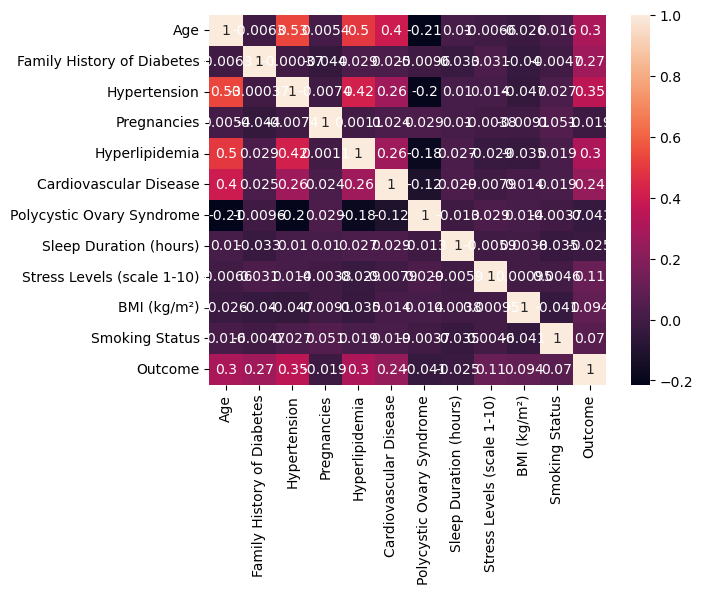

In [8]:
#Correlation Matrix
sns.heatmap(processed_df[['Age', 'Family History of Diabetes', 'Hypertension', 'Pregnancies', 'Hyperlipidemia', 'Cardiovascular Disease', 'Polycystic Ovary Syndrome', 'Sleep Duration (hours)', 'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status','Outcome']].corr(), annot=True)

In [ ]:
sns.pairplot(processed_df, hue='Outcome')

KeyboardInterrupt: 

In [ ]:
#Frequency distribution to check for Normally distributed features
px.histogram(processed_df, x=['BMI (kg/m²)', 'Age'], title='Frequency Distribution').show()

In [ ]:
px.histogram(processed_df, x=['Sleep Duration (hours)'], title='Frequency Distribution').show()

In [ ]:
px.histogram(processed_df, x=['Stress Levels (scale 1-10)', 'Pregnancies'], title='Frequency Distribution').show()

In [ ]:
#Box Plot to visualise Outliers
px.box(processed_df[['Age', 'Pregnancies', 'Sleep Duration (hours)', 'Stress Levels (scale 1-10)',	'BMI (kg/m²)']])

### `Data Preprocessing`

In [8]:
#eliminating outliers in BMI, where values greater than 50 are medically considered rare
processed_df = processed_df.drop(processed_df[processed_df['BMI (kg/m²)']>50].index)
processed_df.count()

Age                           1980
Ethnicity                     1980
Family History of Diabetes    1980
Hypertension                  1980
Hyperlipidemia                1980
Cardiovascular Disease        1980
Polycystic Ovary Syndrome     1980
Pregnancies                   1980
Smoking Status                1980
Sleep Duration (hours)        1980
Stress Levels (scale 1-10)    1980
BMI (kg/m²)                   1980
Outcome                       1980
dtype: int64

In [9]:
processed_df.reset_index().drop('index', axis=1)

,Age,Ethnicity,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Outcome
0,50,Caucasian,0,0,1,0,0,2,1,6.1,8,24.6,0
1,43,Caucasian,0,0,0,0,0,2,0,4.7,3,27.3,0
2,52,African,1,1,1,0,0,0,2,5.4,10,24.0,1
3,63,Caucasian,0,1,1,1,0,0,1,8.1,8,26.5,1
4,42,Caucasian,0,0,0,0,0,2,1,9.4,8,18.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,57,Caucasian,0,0,1,1,0,6,1,7.5,10,28.1,0
1976,44,Caucasian,0,0,0,0,0,0,0,7.8,8,18.5,0
1977,34,Caucasian,0,0,0,0,0,0,1,5.7,8,26.4,0
1978,43,African,0,0,0,0,0,1,1,6.7,9,36.2,1


#### `Training & Testing Set Split`

In [10]:
#creating training(70%), testing(15%) & validation(15%) sets from processed_df

X = processed_df.drop('Outcome', axis=1)
y = processed_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [11]:
X_train.head()

,Age,Ethnicity,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²)
185,53,Caucasian,0,0,1,0,0,0,1,6.1,2,35.7
1751,53,Asian,0,1,1,0,0,3,1,4.6,8,29.6
330,44,African,0,0,0,0,0,0,0,6.6,9,26.5
249,49,African,1,0,0,0,0,0,0,4.5,5,32.6
232,45,Hispanic,1,0,0,0,0,2,1,7.2,2,18.5


### `Featuring Scaling & One Hot Encoding`

In [12]:
#performing z-score standardisation on numerical features
scaler = StandardScaler()
scaler.fit(X_train[['Age', 'Pregnancies', 'Sleep Duration (hours)',	'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status']])

X_train[['Age', 'Pregnancies', 'Sleep Duration (hours)',	'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status']] = scaler.transform(X_train[['Age', 'Pregnancies', 'Sleep Duration (hours)',	'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status']])
X_test[['Age', 'Pregnancies', 'Sleep Duration (hours)',	'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status']] = scaler.transform(X_test[['Age', 'Pregnancies', 'Sleep Duration (hours)',	'Stress Levels (scale 1-10)',	'BMI (kg/m²)', 'Smoking Status']])



#performing one hot encoding for the Ethnicity column
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(X_train[['Ethnicity']]) 

X_train_encoded = encoder.transform(X_train[['Ethnicity']])
X_test_encoded = encoder.transform(X_test[['Ethnicity']])


X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['Ethnicity']))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['Ethnicity']))


X_train = pd.concat([X_train.drop(columns=['Ethnicity']).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=['Ethnicity']).reset_index(drop=True), X_test_encoded_df], axis=1)


X_train

,Age,Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_Other
0,0.662205,0,0,1,0,0,-1.444082,0.717250,-0.638668,-1.243513,1.467637,0.0,0.0,1.0,0.0,0.0
1,0.662205,0,1,1,0,0,0.707777,0.717250,-1.683187,0.848230,0.274421,0.0,1.0,0.0,0.0,0.0
2,-0.106933,0,0,0,0,0,-1.444082,-0.783574,-0.290496,1.196853,-0.331967,1.0,0.0,0.0,0.0,0.0
3,0.320366,1,0,0,0,0,-1.444082,-0.783574,-1.752821,-0.197641,0.861248,1.0,0.0,0.0,0.0,0.0
4,-0.021473,1,0,0,0,0,-0.009509,0.717250,0.127312,-1.243513,-1.896841,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,-0.363312,1,0,0,0,0,-0.009509,-0.783574,-0.429765,1.196853,0.333104,0.0,1.0,0.0,0.0,0.0
1580,-0.619691,1,0,0,0,0,-1.444082,-0.783574,-2.100994,0.499606,-0.136358,0.0,0.0,1.0,0.0,0.0
1581,-1.816128,0,0,0,0,1,-0.726796,-0.783574,0.614753,-0.894889,-1.544744,0.0,1.0,0.0,0.0,0.0
1582,-0.021473,0,0,0,0,1,-0.726796,-0.783574,-0.081592,-0.894889,0.254860,0.0,0.0,0.0,1.0,0.0


In [13]:
X_train=X_train[['Age', 'Pregnancies', 'Smoking Status','Sleep Duration (hours)', 'Stress Levels (scale 1-10)',	'BMI (kg/m²)','Family History of Diabetes','Hypertension','Hyperlipidemia','Cardiovascular Disease','Polycystic Ovary Syndrome','Ethnicity_African',	'Ethnicity_Asian',	'Ethnicity_Caucasian',	'Ethnicity_Hispanic',	'Ethnicity_Other']]

In [14]:
X_train

,Age,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_Other
0,0.662205,-1.444082,0.717250,-0.638668,-1.243513,1.467637,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0
1,0.662205,0.707777,0.717250,-1.683187,0.848230,0.274421,0,1,1,0,0,0.0,1.0,0.0,0.0,0.0
2,-0.106933,-1.444082,-0.783574,-0.290496,1.196853,-0.331967,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,0.320366,-1.444082,-0.783574,-1.752821,-0.197641,0.861248,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,-0.021473,-0.009509,0.717250,0.127312,-1.243513,-1.896841,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,-0.363312,-0.009509,-0.783574,-0.429765,1.196853,0.333104,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1580,-0.619691,-1.444082,-0.783574,-2.100994,0.499606,-0.136358,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0
1581,-1.816128,-0.726796,-0.783574,0.614753,-0.894889,-1.544744,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0
1582,-0.021473,-0.726796,-0.783574,-0.081592,-0.894889,0.254860,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0


In [15]:
X_test=X_test[['Age', 'Pregnancies', 'Smoking Status','Sleep Duration (hours)', 'Stress Levels (scale 1-10)',	'BMI (kg/m²)','Family History of Diabetes','Hypertension','Hyperlipidemia','Cardiovascular Disease','Polycystic Ovary Syndrome','Ethnicity_African',	'Ethnicity_Asian',	'Ethnicity_Caucasian',	'Ethnicity_Hispanic',	'Ethnicity_Other']]

In [16]:
X_test

,Age,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_Other
0,0.149447,-0.726796,-0.783574,0.057677,-0.197641,-0.038554,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
1,1.004045,0.707777,2.218075,-0.290496,1.545477,0.783005,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,-0.363312,-0.726796,-0.783574,-0.847572,1.196853,0.215738,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,-0.277852,-0.009509,-0.783574,-0.499399,0.150982,0.470030,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
4,-0.534232,-0.726796,-0.783574,-0.290496,0.499606,-0.527577,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.576746,-0.009509,-0.783574,1.380734,-1.592136,3.286802,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
392,0.320366,-0.726796,-0.783574,0.545119,1.545477,-1.212209,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0
393,-2.243427,-0.726796,-0.783574,-1.474283,1.545477,-0.136358,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
394,0.234907,-0.009509,-0.783574,1.241464,-1.243513,-0.801429,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [17]:
X_train.describe()

,Age,Pregnancies,Smoking Status,Sleep Duration (hours),Stress Levels (scale 1-10),BMI (kg/m²),Family History of Diabetes,Hypertension,Hyperlipidemia,Cardiovascular Disease,Polycystic Ovary Syndrome,Ethnicity_African,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Ethnicity_Other
count,1.584000e+03,1.584000e+03,1.584000e+03,1.584000e+03,1.584000e+03,1.584000e+03,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,3.207311e-16,2.915737e-17,3.925031e-17,-4.698823e-16,-4.037175e-17,-6.078191e-16,0.290404,0.207702,0.176136,0.078914,0.133207,0.205808,0.150884,0.482955,0.110480,0.049874
std,1.000316e+00,1.000316e+00,1.000316e+00,1.000316e+00,1.000316e+00,1.000316e+00,0.454092,0.405790,0.381056,0.269690,0.339906,0.404419,0.358049,0.499867,0.313586,0.217753
min,-2.328887e+00,-1.444082e+00,-7.835744e-01,-2.100994e+00,-1.592136e+00,-1.896841e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.051512e-01,-7.267955e-01,-7.835744e-01,-7.083029e-01,-8.948889e-01,-7.036248e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.147285e-02,-9.509474e-03,-7.835744e-01,-1.195745e-02,1.509822e-01,-1.899286e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.622055e-01,7.077766e-01,7.172501e-01,7.540226e-01,8.482297e-01,6.265173e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,2.969620e+00,2.859635e+00,2.218075e+00,2.077079e+00,1.545477e+00,4.245286e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### `Model Training & Hyperparameter Tuning`

In [18]:
param_grid = {
    'penalty': ['elasticnet'],  
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9], 
    'solver': ['saga']  
}

log_reg = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='recall')
#cv=5 means number of times the training set is parted while performing cross-validation
#scoring=recall tells the gridSearch algorithm to optimise the model to reduce false-negatives


grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)


best_model = grid_search.best_estimator_

Best Hyperparameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Cross-validation Accuracy: 0.5991608391608392


### `Model Testing & Error Metric Evaluation`

In [19]:
y_test_pred = best_model.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       251
           1       0.63      0.57      0.60       145

    accuracy                           0.72       396
   macro avg       0.70      0.69      0.69       396
weighted avg       0.71      0.72      0.72       396



In [20]:
#ALTERNATE
#using the predict_proba method to calculate the probabilities and defining a custom probability threshold of 35% to minimise false positives.

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_pred_proba > 0.35).astype(int)


print("Classification Report with custom threshold:")
print(classification_report(y_test, y_pred_custom))


Classification Report with custom threshold:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       251
           1       0.58      0.77      0.66       145

    accuracy                           0.71       396
   macro avg       0.71      0.73      0.71       396
weighted avg       0.74      0.71      0.72       396



In [21]:
import pickle
filename='picklemodel.pkl'
pickle.dump(best_model,open(filename,'wb'))

In [22]:
filename2='scalermodel.pkl'
pickle.dump(scaler,open(filename2,'wb'))